In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("taweilo/loan-approval-classification-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/loan-approval-classification-data


In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings("ignore")
sns.set()

In [3]:
os.listdir("/kaggle/input/loan-approval-classification-data")

['loan_data.csv']

In [4]:
df = pd.read_csv("/kaggle/input/loan-approval-classification-data/loan_data.csv")
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [5]:
df.shape

(45000, 14)

In [6]:
df["loan_status"].value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

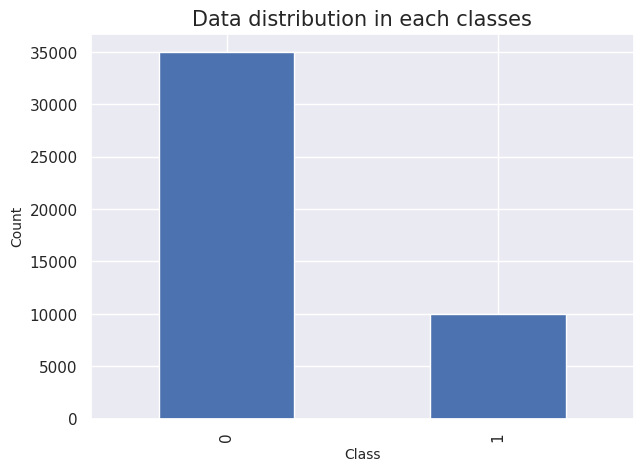

In [7]:
df["loan_status"].value_counts().plot(kind = "bar", figsize = (7, 5))
plt.title("Data distribution in each classes", fontsize = 15)
plt.xlabel("Class", fontsize = 10)
plt.ylabel("Count", fontsize = 10)
plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [9]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [10]:
df.duplicated().sum()

0

In [11]:
df.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

In [12]:
numerical_columns, categorical_columns = [], []
for column in df.columns:
    if df[column].dtype == "object" or df[column].nunique() < 15:
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

In [13]:
print(f"Number of categorical columns: {len(categorical_columns)}")
print(f"Categorical columns: {categorical_columns}")
print(f"Number of numerical columns: {len(numerical_columns)}")
print(f"Numerical columns: {numerical_columns}")

Number of categorical columns: 6
Categorical columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file', 'loan_status']
Number of numerical columns: 8
Numerical columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


In [14]:
df1 = df[df['loan_status'] == 1]
df0 = df[df['loan_status'] == 0].sample(df1.shape[0], random_state = 101)
df_b = pd.concat([df0, df1])
df_b.shape

(20000, 14)

Column: person_gender
Number of unique values: 2
Unique values: ['male' 'female']
Value counts of each unique values: person_gender
male      11055
female     8945
Name: count, dtype: int64


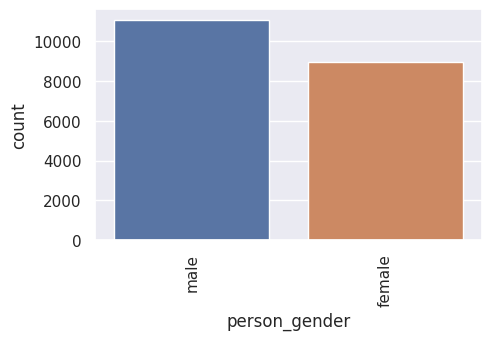

********************************************************************************
Column: person_education
Number of unique values: 5
Unique values: ['Bachelor' 'High School' 'Master' 'Associate' 'Doctorate']
Value counts of each unique values: person_education
Bachelor       6086
Associate      5303
High School    5276
Master         3068
Doctorate       267
Name: count, dtype: int64


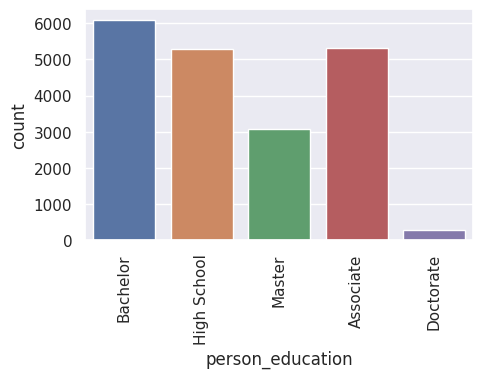

********************************************************************************
Column: person_home_ownership
Number of unique values: 4
Unique values: ['RENT' 'MORTGAGE' 'OWN' 'OTHER']
Value counts of each unique values: person_home_ownership
RENT        12045
MORTGAGE     6893
OWN           999
OTHER          63
Name: count, dtype: int64


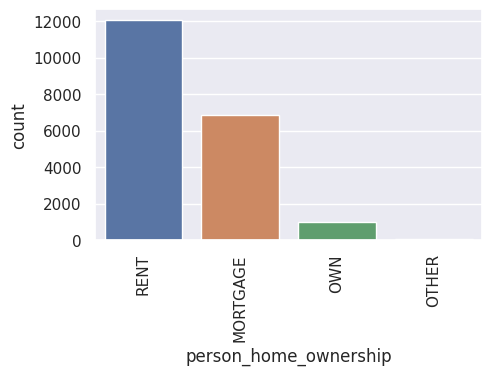

********************************************************************************
Column: loan_intent
Number of unique values: 6
Unique values: ['VENTURE' 'EDUCATION' 'DEBTCONSOLIDATION' 'HOMEIMPROVEMENT' 'MEDICAL'
 'PERSONAL']
Value counts of each unique values: loan_intent
MEDICAL              4120
EDUCATION            3745
DEBTCONSOLIDATION    3573
PERSONAL             3282
VENTURE              3025
HOMEIMPROVEMENT      2255
Name: count, dtype: int64


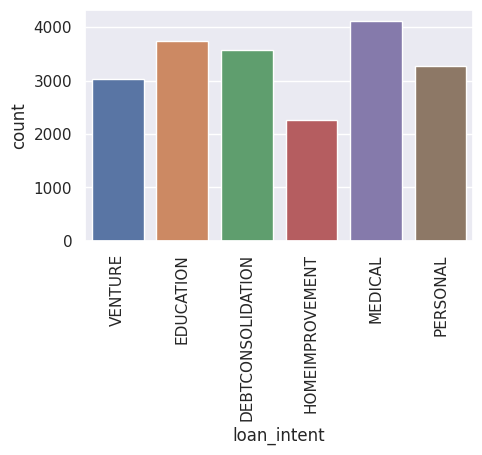

********************************************************************************
Column: previous_loan_defaults_on_file
Number of unique values: 2
Unique values: ['Yes' 'No']
Value counts of each unique values: previous_loan_defaults_on_file
No     13484
Yes     6516
Name: count, dtype: int64


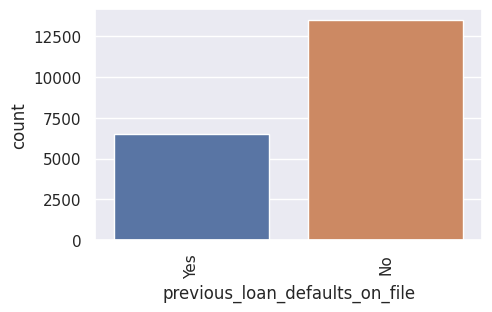

********************************************************************************
Column: loan_status
Number of unique values: 2
Unique values: [0 1]
Value counts of each unique values: loan_status
0    10000
1    10000
Name: count, dtype: int64


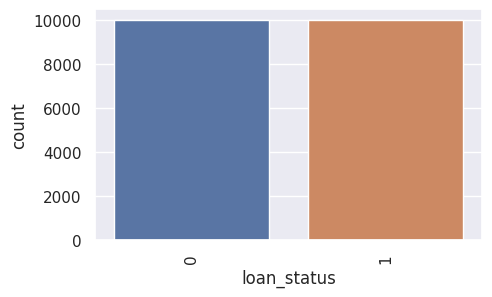

********************************************************************************


In [15]:
for column in categorical_columns:
    print(f"Column: {column}")
    print(f"Number of unique values: {df_b[column].nunique()}")
    print(f"Unique values: {df_b[column].unique()}")
    print(f"Value counts of each unique values: {df_b[column].value_counts()}")
    plt.figure(figsize = (5, 3))
    sns.countplot(data = df_b, x = column)
    plt.xticks(rotation = 90)
    plt.show()
    print("*" * 80)

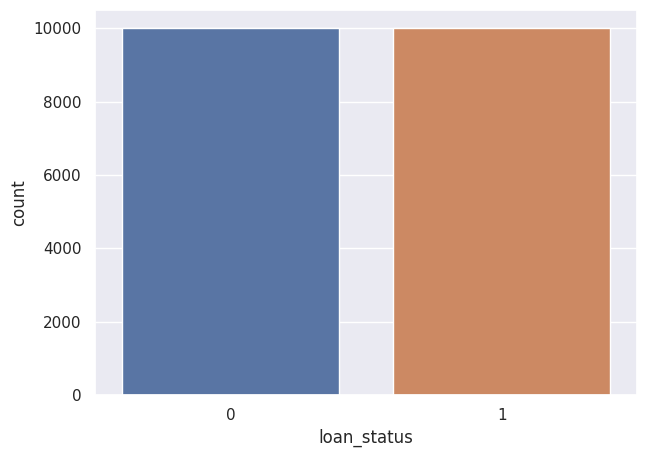

In [16]:
plt.figure(figsize = (7, 5))
sns.countplot(data = df_b, x = "loan_status")
plt.show()

In [17]:
df_b = df_b[df_b['person_home_ownership'] != "OTHER"]

In [18]:
df_b = df_b[df_b['person_education'] != "Doctorate"]

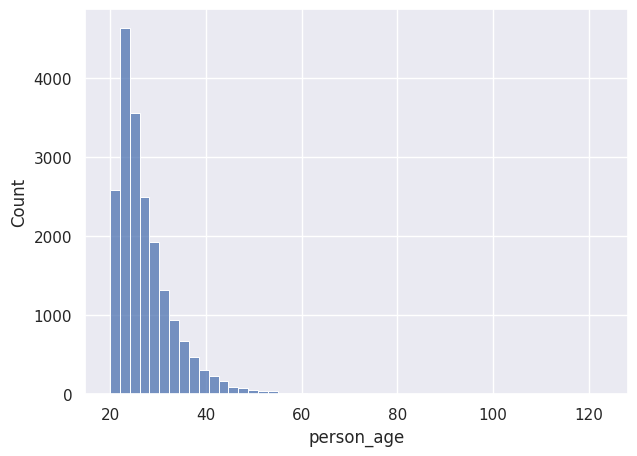

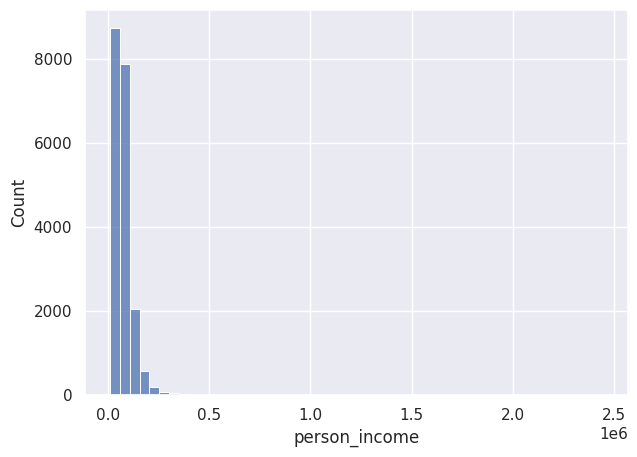

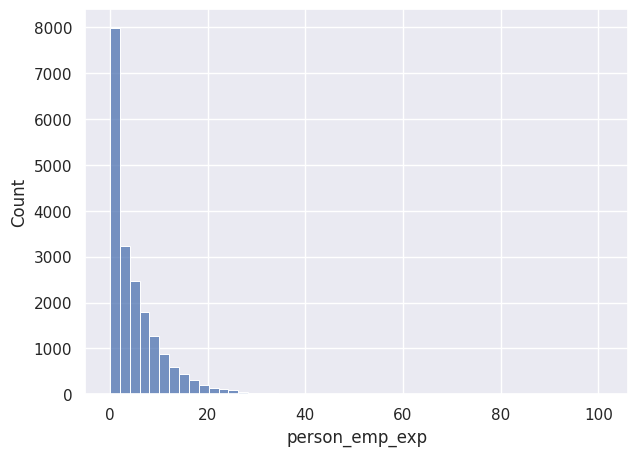

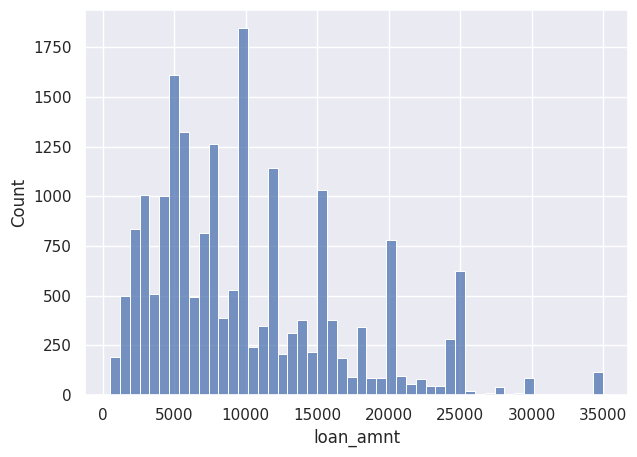

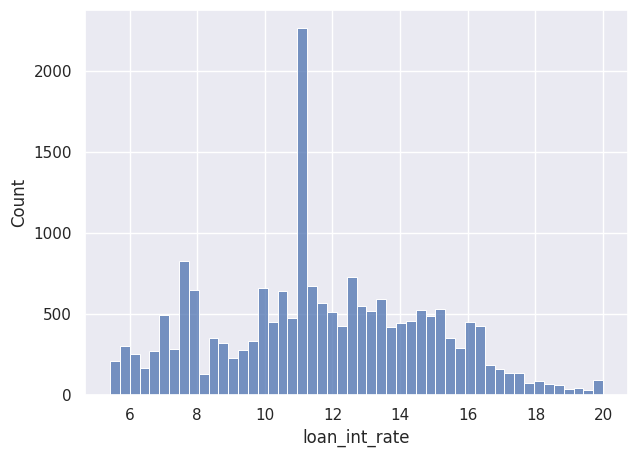

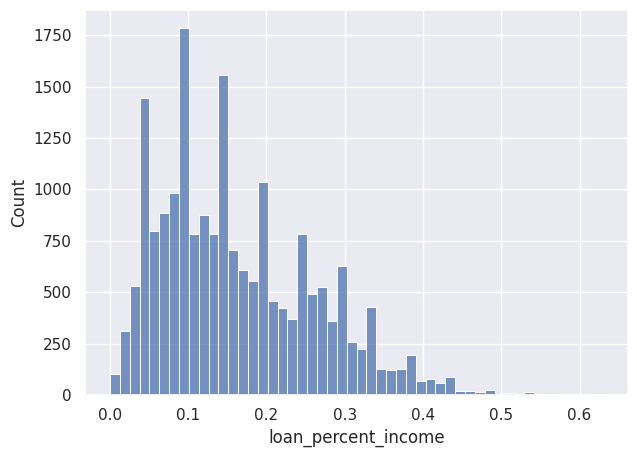

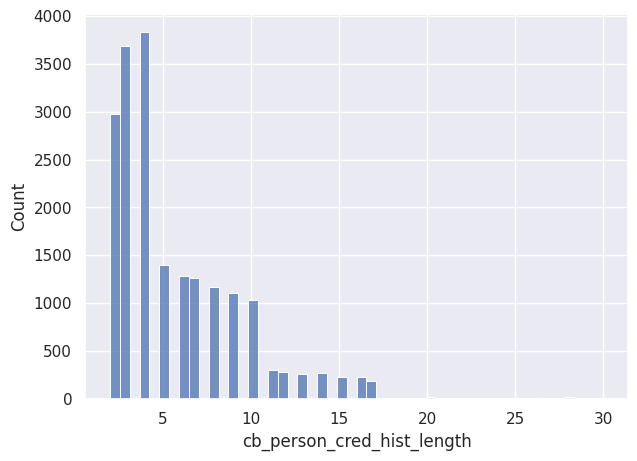

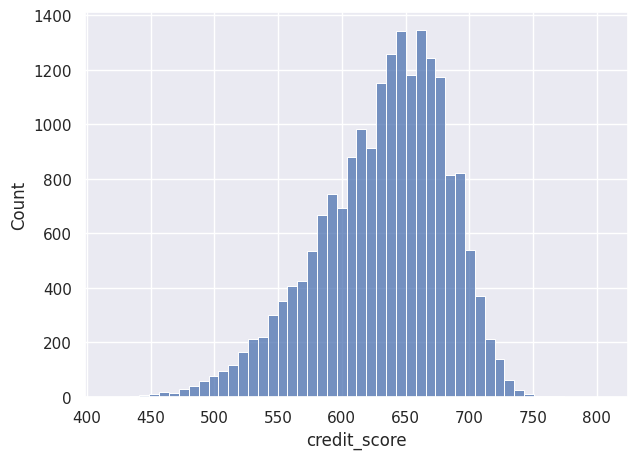

In [19]:
for column in numerical_columns:
    plt.figure(figsize = (7, 5))
    sns.histplot(data = df_b, x = column, bins = 50)
    plt.show()

In [20]:
df_b["cb_person_cred_hist_length"].value_counts()

cb_person_cred_hist_length
4.0     3829
3.0     3681
2.0     2973
5.0     1401
6.0     1285
7.0     1260
8.0     1174
9.0     1109
10.0    1036
11.0     304
12.0     282
14.0     268
13.0     265
16.0     233
15.0     226
17.0     187
20.0      21
28.0      16
23.0      14
24.0      14
22.0      13
19.0      13
18.0      12
27.0      11
21.0      10
29.0       9
26.0       8
30.0       8
25.0       8
Name: count, dtype: int64

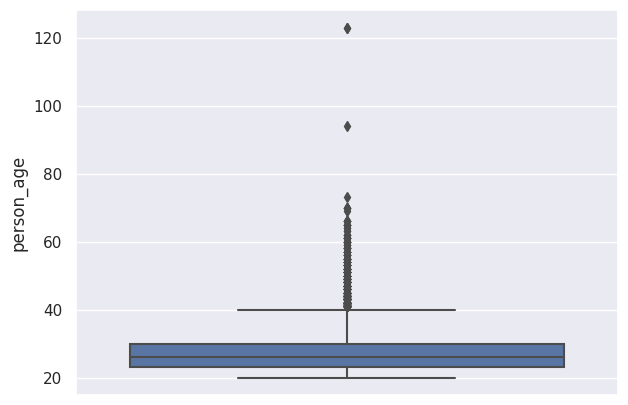

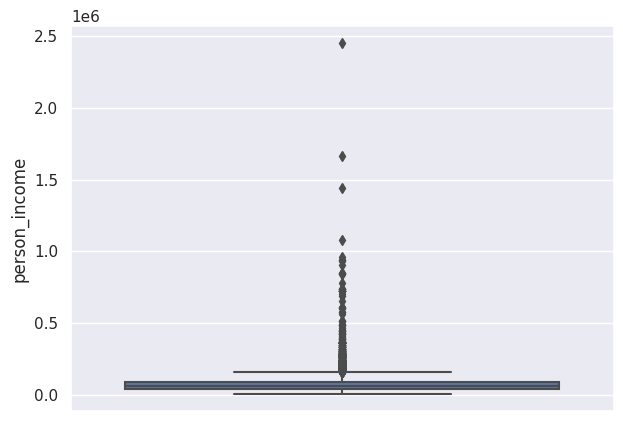

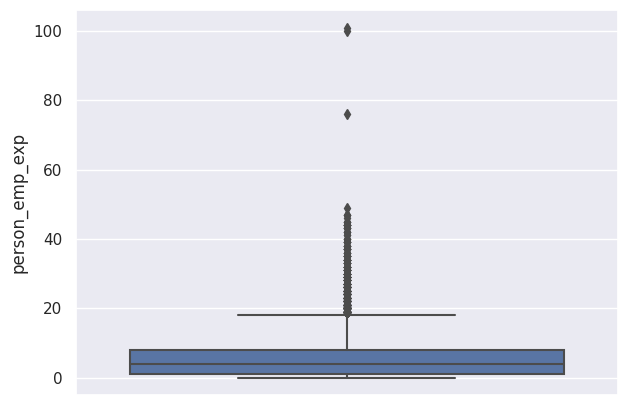

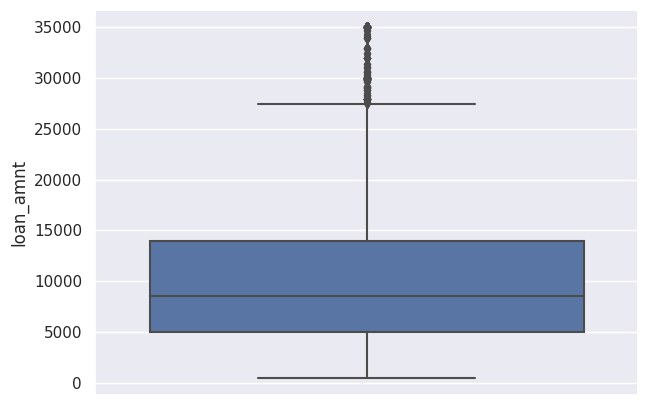

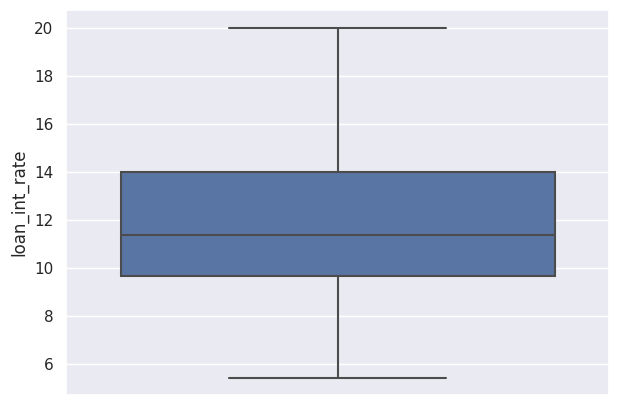

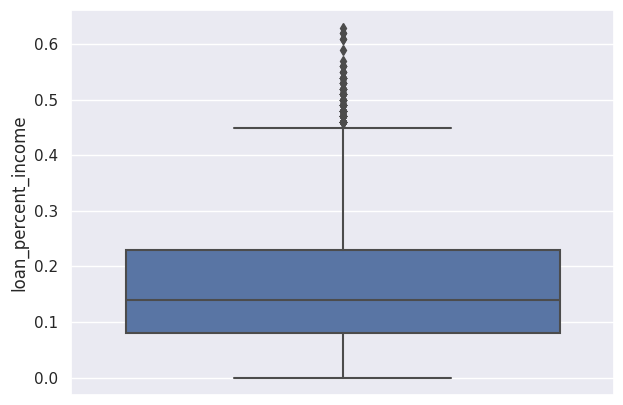

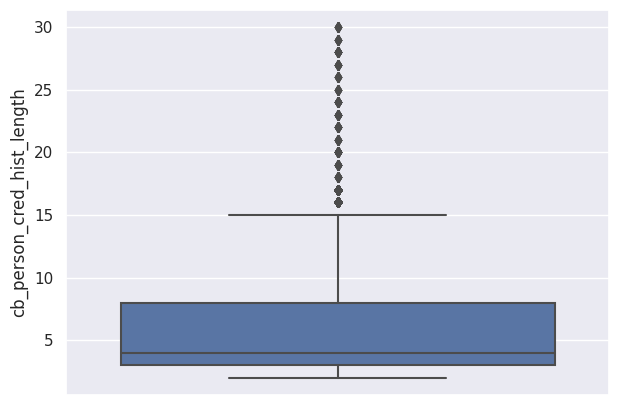

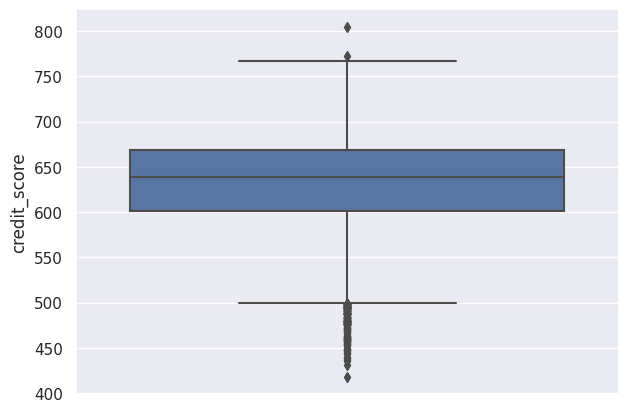

In [21]:
for column in numerical_columns:
    plt.figure(figsize = (7, 5))
    sns.boxplot(data = df_b, y = column)
    plt.show()

In [22]:
df_b[df_b['person_age'] > 40].shape[0]

765

In [23]:
df_b = df_b[df_b['person_age'] < 40]

In [24]:
df_b[df_b['person_income'] > 200000].shape[0]

388

In [25]:
df_b = df_b[df_b['person_income'] < 200000]

In [26]:
df_b[df_b['person_emp_exp'] > 19].shape[0]

10

In [27]:
df_b = df_b[df_b['person_emp_exp'] < 19]

In [28]:
df_b[df_b['loan_amnt'] > 27500].shape[0]

220

In [29]:
df_b = df_b[df_b['loan_amnt'] < 27500]

In [30]:
df_b[df_b['loan_percent_income'] > 0.45].shape[0]

99

In [31]:
df_b = df_b[df_b['loan_percent_income'] < 0.45]

In [32]:
df_b[df_b['cb_person_cred_hist_length'] > 15].shape[0]

181

In [33]:
df_b = df_b[df_b['cb_person_cred_hist_length'] < 15]

In [34]:
df_b[df_b['credit_score'] > 760].shape[0]

0

In [35]:
df_b[df_b['credit_score'] <= 500].shape[0]

212

In [36]:
df_b = df_b[df_b['credit_score'] > 500]

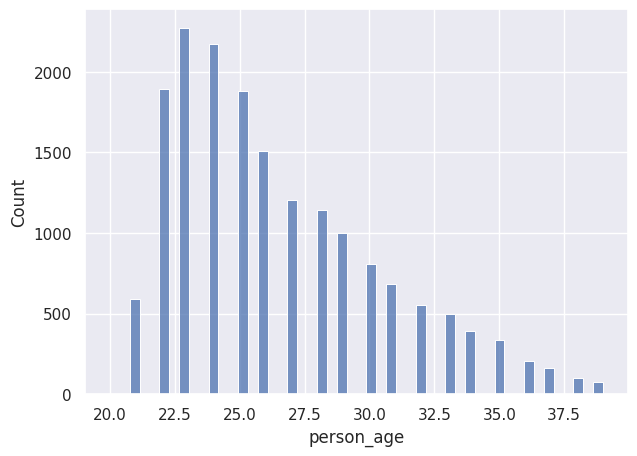

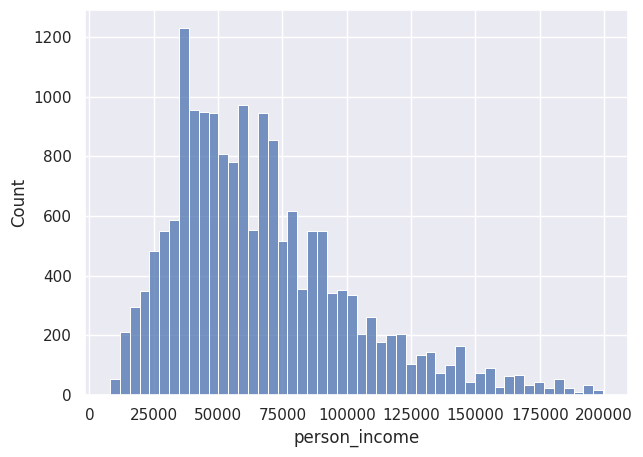

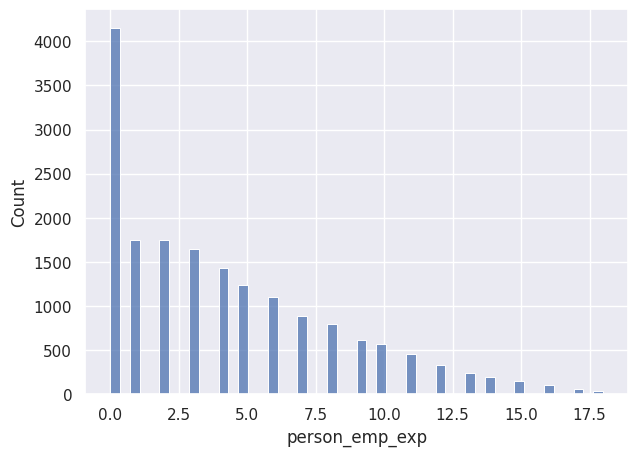

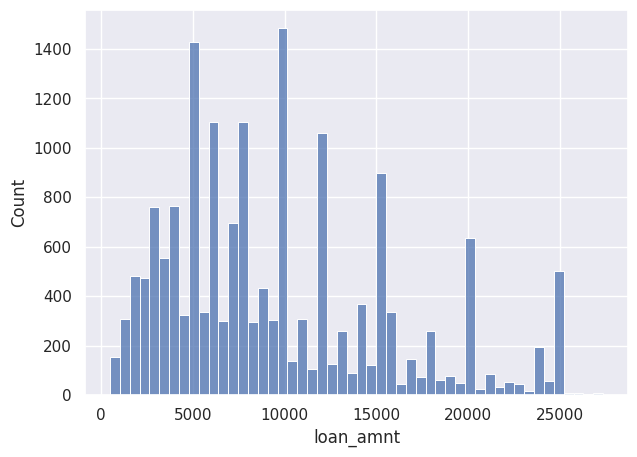

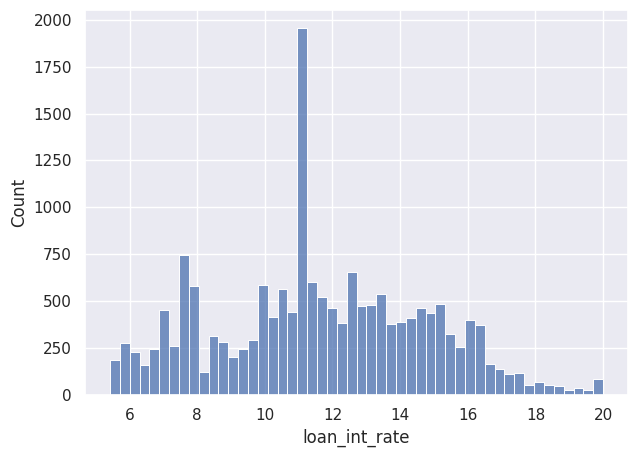

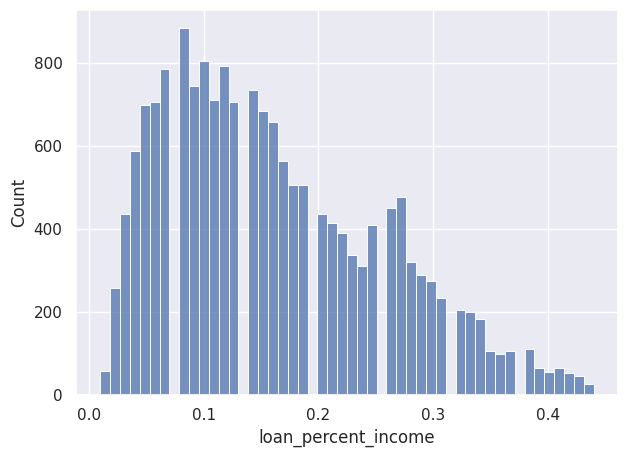

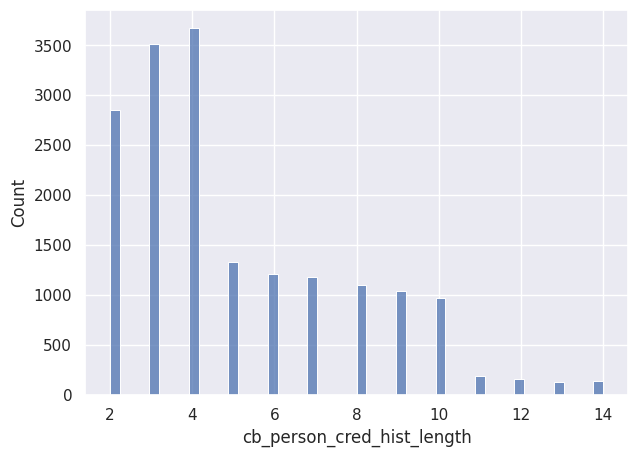

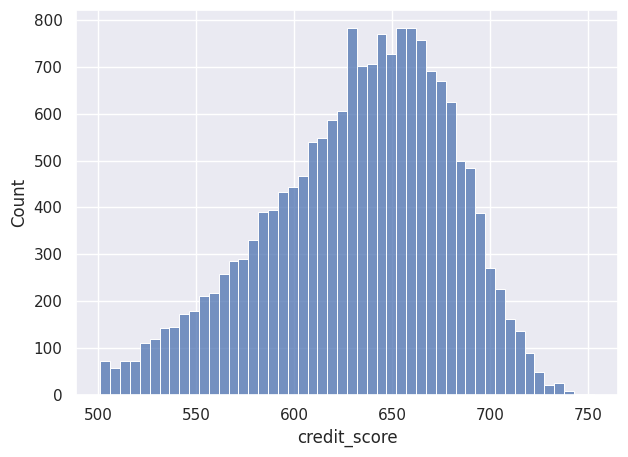

In [37]:
for column in numerical_columns:
    plt.figure(figsize = (7, 5))
    sns.histplot(data = df_b, x = column, bins = 50)
    plt.show()

In [38]:
df_b.shape

(17501, 14)

In [39]:
df_b[df_b['person_age'] > 35.0].shape

(549, 14)

In [40]:
df_b = df_b[df_b['person_age'] < 35.0]

In [41]:
df_b[df_b['person_income'] > 110000].shape

(1877, 14)

In [42]:
df_b = df_b[df_b['person_income'] < 110000]

In [43]:
df_b[df_b['person_emp_exp'] > 12.5].shape

(163, 14)

In [44]:
df_b = df_b[df_b['person_emp_exp'] < 12.5]

In [45]:
df_b[df_b['loan_int_rate'] > 18].shape

(247, 14)

In [46]:
df_b = df_b[df_b['loan_int_rate'] < 18]

In [47]:
df_b[df_b['loan_percent_income'] > 0.3].shape

(1447, 14)

In [48]:
df_b.shape

(14326, 14)

In [49]:
df_b = df_b[df_b['loan_percent_income'] <= 0.3]

In [50]:
df_b[df_b['cb_person_cred_hist_length'] > 10].shape

(48, 14)

In [51]:
df_b = df_b[df_b['cb_person_cred_hist_length'] <= 10]

In [52]:
df_b[df_b['credit_score'] < 525].shape

(261, 14)

In [53]:
df_b = df_b[df_b['credit_score'] > 525]

In [54]:
df_b.shape

(12553, 14)

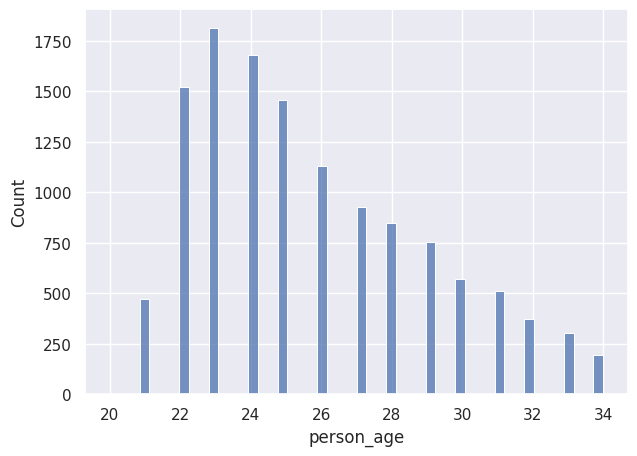

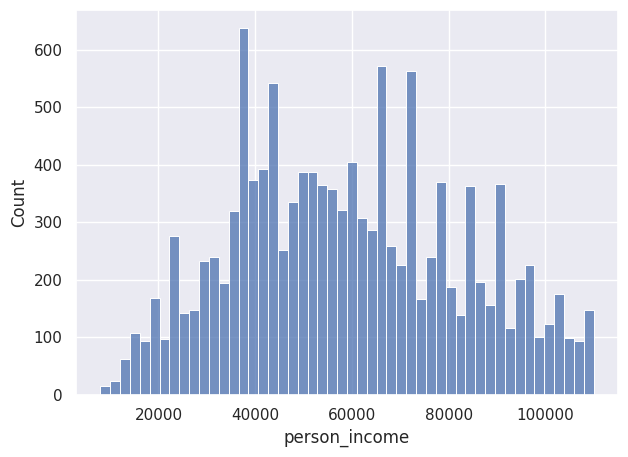

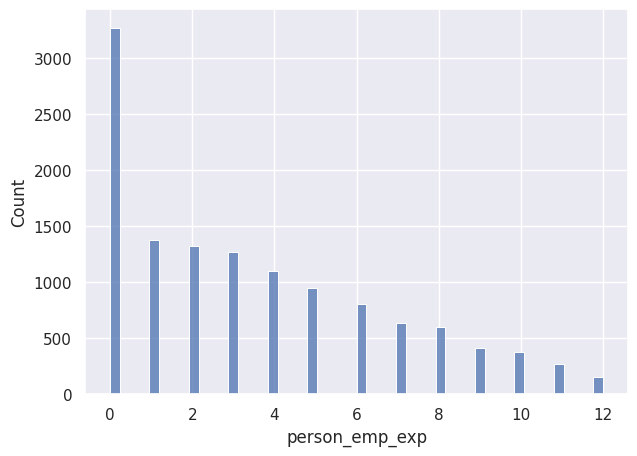

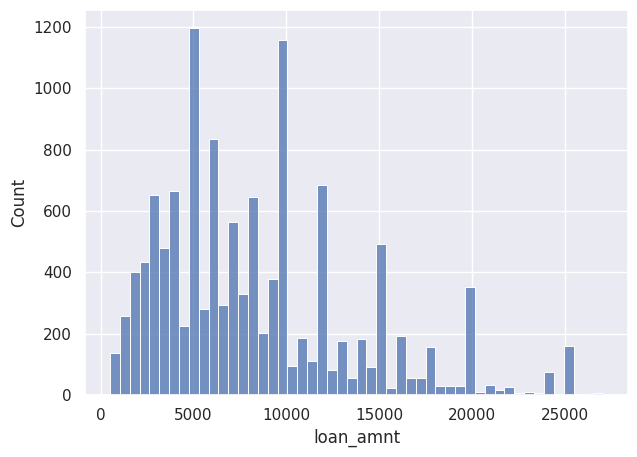

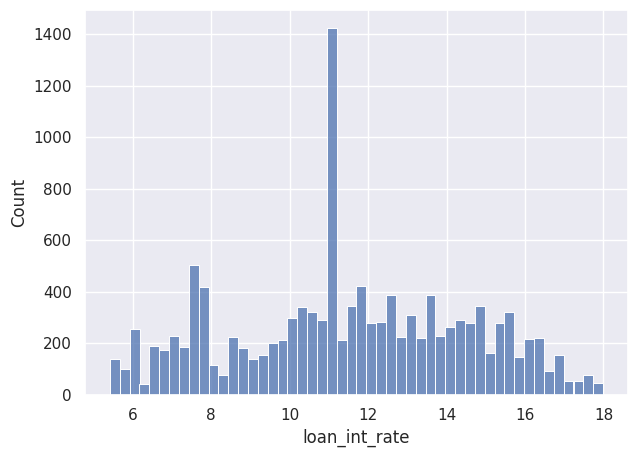

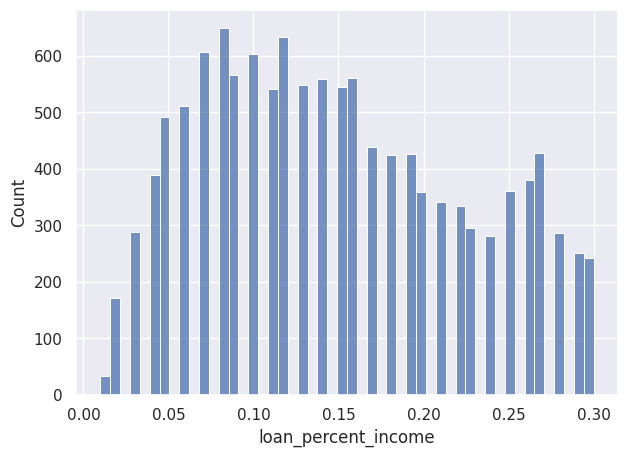

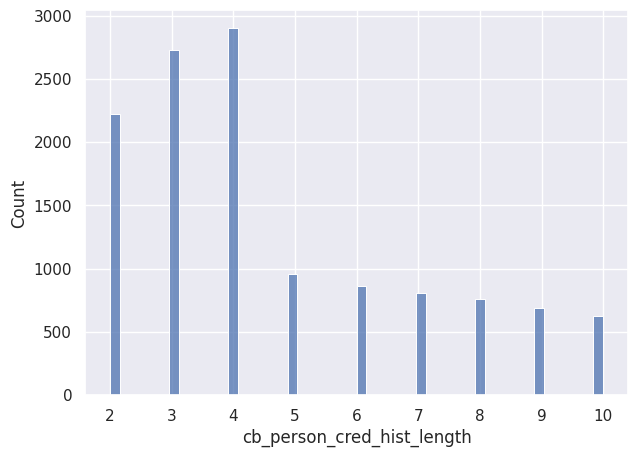

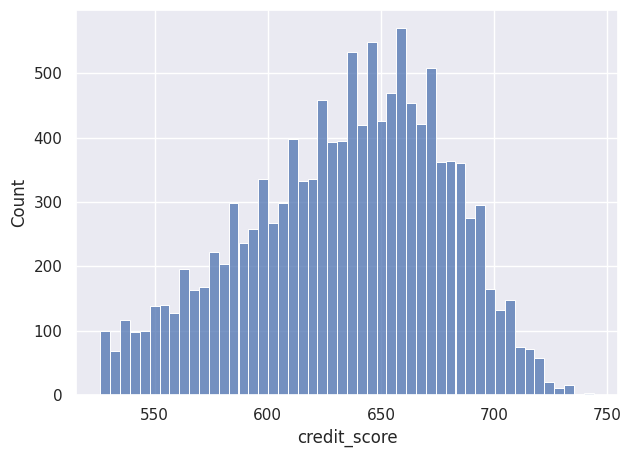

In [55]:
for column in numerical_columns:
    plt.figure(figsize = (7, 5))
    sns.histplot(data = df_b, x = column, bins = 50)
    plt.show()

In [56]:
df_b['loan_status'].value_counts()

loan_status
0    6458
1    6095
Name: count, dtype: int64

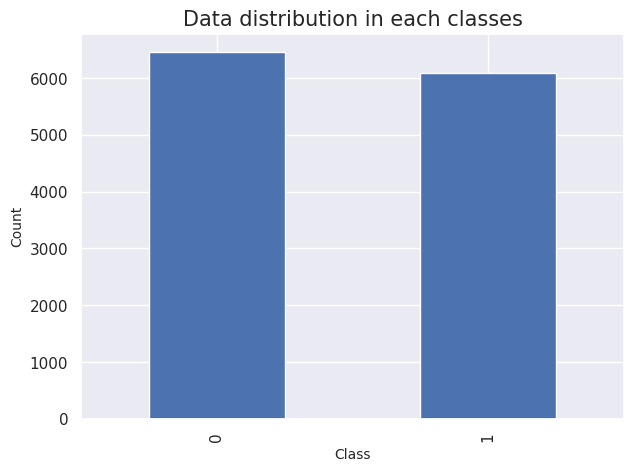

In [57]:
df_b['loan_status'].value_counts().plot(kind = "bar", figsize = (7, 5))
plt.title("Data distribution in each classes", fontsize = 15)
plt.xlabel("Class", fontsize = 10)
plt.ylabel("Count", fontsize = 10)
plt.show()

Column: person_gender
Number of unique values: 2
Unique values: ['male' 'female']
Value counts of each unique values: person_gender
male      6885
female    5668
Name: count, dtype: int64


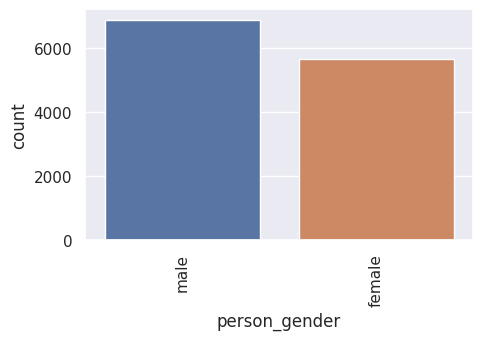

********************************************************************************
Column: person_education
Number of unique values: 4
Unique values: ['High School' 'Bachelor' 'Associate' 'Master']
Value counts of each unique values: person_education
Bachelor       4037
High School    3275
Associate      3227
Master         2014
Name: count, dtype: int64


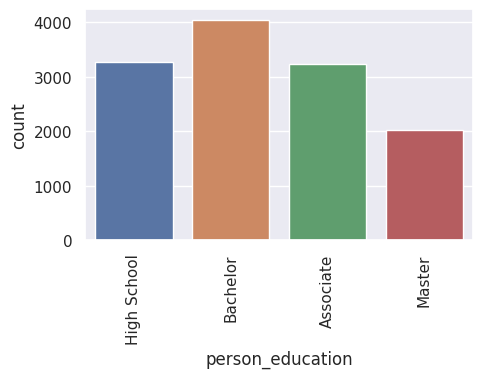

********************************************************************************
Column: person_home_ownership
Number of unique values: 3
Unique values: ['RENT' 'MORTGAGE' 'OWN']
Value counts of each unique values: person_home_ownership
RENT        8031
MORTGAGE    3890
OWN          632
Name: count, dtype: int64


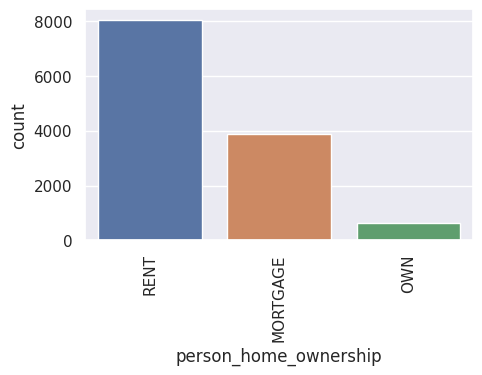

********************************************************************************
Column: loan_intent
Number of unique values: 6
Unique values: ['VENTURE' 'DEBTCONSOLIDATION' 'EDUCATION' 'MEDICAL' 'HOMEIMPROVEMENT'
 'PERSONAL']
Value counts of each unique values: loan_intent
MEDICAL              2662
EDUCATION            2410
DEBTCONSOLIDATION    2206
PERSONAL             2058
VENTURE              1868
HOMEIMPROVEMENT      1349
Name: count, dtype: int64


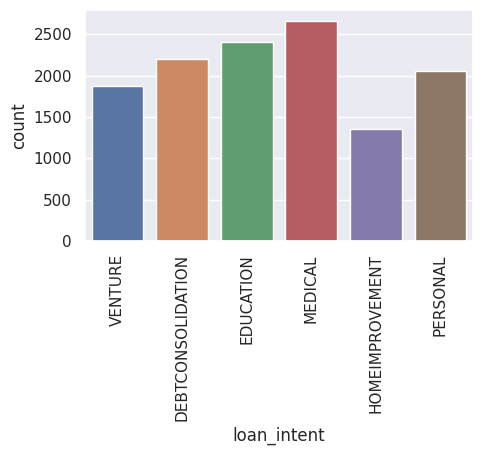

********************************************************************************
Column: previous_loan_defaults_on_file
Number of unique values: 2
Unique values: ['Yes' 'No']
Value counts of each unique values: previous_loan_defaults_on_file
No     8336
Yes    4217
Name: count, dtype: int64


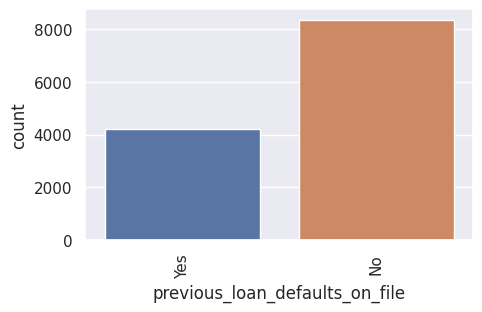

********************************************************************************
Column: loan_status
Number of unique values: 2
Unique values: [0 1]
Value counts of each unique values: loan_status
0    6458
1    6095
Name: count, dtype: int64


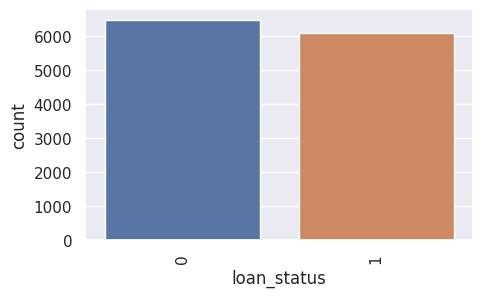

********************************************************************************


In [58]:
for column in categorical_columns:
    print(f"Column: {column}")
    print(f"Number of unique values: {df_b[column].nunique()}")
    print(f"Unique values: {df_b[column].unique()}")
    print(f"Value counts of each unique values: {df_b[column].value_counts()}")
    plt.figure(figsize = (5, 3))
    sns.countplot(data = df_b, x = column)
    plt.xticks(rotation = 90)
    plt.show()
    print("*" * 80)

In [59]:
df_b.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,12553.000000,12553.000000,12553.000000,12553.000000,12553.000000,12553.000000,12553.000000,12553.000000,12553.000000
mean,25.755835,59179.051063,3.454792,8385.802438,11.499857,0.148239,4.651079,633.571577,0.485541
std,3.264335,23462.493920,3.266969,5289.116679,2.996145,0.076059,2.360272,44.056255,0.499811
min,20.000000,8000.000000,0.000000,500.000000,5.420000,0.010000,2.000000,526.000000,0.000000
25%,23.000000,40666.000000,0.000000,4500.000000,9.400000,0.080000,3.000000,603.000000,0.000000
50%,25.000000,58254.000000,3.000000,7066.000000,11.260000,0.140000,4.000000,639.000000,0.000000
75%,28.000000,76543.000000,6.000000,11200.000000,13.820000,0.210000,6.000000,667.000000,1.000000
max,34.000000,109978.000000,12.000000,27050.000000,17.990000,0.300000,10.000000,744.000000,1.000000


In [60]:
df_b.reset_index(drop = True, inplace = True)

In [61]:
X = df_b.drop(columns = ['loan_status'], axis = 1)
y = df_b['loan_status']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101, stratify = y)

In [63]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.33, random_state = 101, stratify = y_test)

In [64]:
print(f"Size of training set: {len(X_train)}")
print(f"Size of test set: {len(X_test)}")
print(f"Size of validation set: {len(X_val)}")

Size of training set: 8787
Size of test set: 2523
Size of validation set: 1243


In [65]:
X_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
X_val.reset_index(drop =  True, inplace = True)
y_val.reset_index(drop = True, inplace = True)

In [66]:
X_train.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
0,21.0,male,Bachelor,24238.0,0,RENT,6000.0,PERSONAL,9.88,0.25,2.0,608,No
1,32.0,male,High School,88798.0,7,MORTGAGE,12000.0,EDUCATION,12.42,0.14,7.0,613,Yes
2,28.0,male,Bachelor,39702.0,4,RENT,10234.0,MEDICAL,7.36,0.26,8.0,615,No
3,27.0,male,Associate,55958.0,5,OWN,14000.0,MEDICAL,11.01,0.25,6.0,555,Yes
4,22.0,male,Associate,20109.0,1,RENT,4801.0,PERSONAL,13.03,0.24,3.0,629,No


In [67]:
ct = ColumnTransformer(transformers = [
    ('encoder', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'), [1, 2, 5, 7, 12]),
    ('scaler', StandardScaler(), [0, 3, 4, 6, 8, 9, 10, 11])
], remainder = 'passthrough')

In [68]:
X_train_f = ct.fit_transform(X_train)
X_test_f = ct.transform(X_test)
X_val_f = ct.transform(X_val)

In [69]:
X_train_f

array([[ 1.        ,  1.        ,  0.        , ...,  1.33051848,
        -1.12863771, -0.58028192],
       [ 1.        ,  0.        ,  1.        , ..., -0.11351216,
         0.98359171, -0.46634937],
       [ 1.        ,  1.        ,  0.        , ...,  1.46179399,
         1.40603759, -0.42077635],
       ...,
       [ 1.        ,  1.        ,  0.        , ..., -0.5073387 ,
         1.40603759, -0.89929305],
       [ 1.        ,  0.        ,  0.        , ..., -1.03244074,
        -0.70619183, -0.78536051],
       [ 0.        ,  0.        ,  1.        , ..., -0.5073387 ,
        -1.12863771, -0.92207956]])

In [70]:
X_train_f.shape

(8787, 20)

In [71]:
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [72]:
train_dataset = MyDataset(X_train_f, y_train)
test_dataset = MyDataset(X_test_f, y_test)
val_dataset = MyDataset(X_val_f, y_val)

In [73]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [75]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


In [94]:
def plot_results(train_accs, train_losses, val_accs, val_losses):
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    xs = np.arange(1, len(train_accs) + 1, 1)
    axes[0].plot(xs, train_accs, label = 'Training')
    axes[0].plot(xs, val_accs, label = 'Validation')
    axes[0].set_title('Training accuracy vs Validation accuracy', fontsize = 15)
    axes[0].set_xlabel('Epoch', fontsize = 10)
    axes[0].set_ylabel('Accuracy', fontsize = 10)
    axes[0].set_xticks(xs)
    axes[0].legend()
    axes[1].plot(xs, train_losses, label = 'Training')
    axes[1].plot(xs, val_losses, label = 'Validation')
    axes[1].set_title('Training loss vs Validation loss', fontsize = 15)
    axes[1].set_xlabel('Epoch', fontsize = 10)
    axes[1].set_ylabel('Loss', fontsize = 10)
    axes[1].set_xticks(xs)
    axes[1].legend()
    plt.tight_layout()
    plt.show()

In [92]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    model.train()
    total_loss = 0
    total_acc = 0
    for x, y in dataloader:
        x, y = x.to(device).float(), y.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        probs = torch.sigmoid(preds)
        preds = (probs > 0.5).float()
        total_acc += (preds == y).sum().item()
    return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [90]:
def val_step(model, criterion, dataloader, device = device):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device).float(), y.to(device).float().unsqueeze(1)
            preds = model(x)
            total_loss += criterion(preds, y).item()
            probs = torch.sigmoid(preds)
            preds = (probs > 0.5).float()
            total_acc += (preds == y).sum().item()
    return total_loss / len(dataloader), 100 * total_acc / len(dataloader.dataset)

In [79]:
def train_model(model, n_epochs, optimizer, train_loader, val_loader, device = device):
    train_accs, train_losses, val_accs, val_losses = [], [], [], []
    criterion = nn.BCEWithLogitsLoss()
    pbar = trange(n_epochs)
    for epoch in pbar:
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        val_loss, val_acc = val_step(model, criterion, val_loader, device)
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        pbar.set_description(f'Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}')
    plot_results(train_accs, train_losses, val_accs, val_losses)
    return {'train_accs': train_accs, 'train_loss': train_loss, 'val_accs': val_accs, 'val_loss': val_loss}

In [100]:
class NN_model1(nn.Module):
    def __init__(self, input_size):
        super(NN_model1, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.235 | Val Loss: 0.263 | Train Acc: 88.881 | Val Acc: 86.726: 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


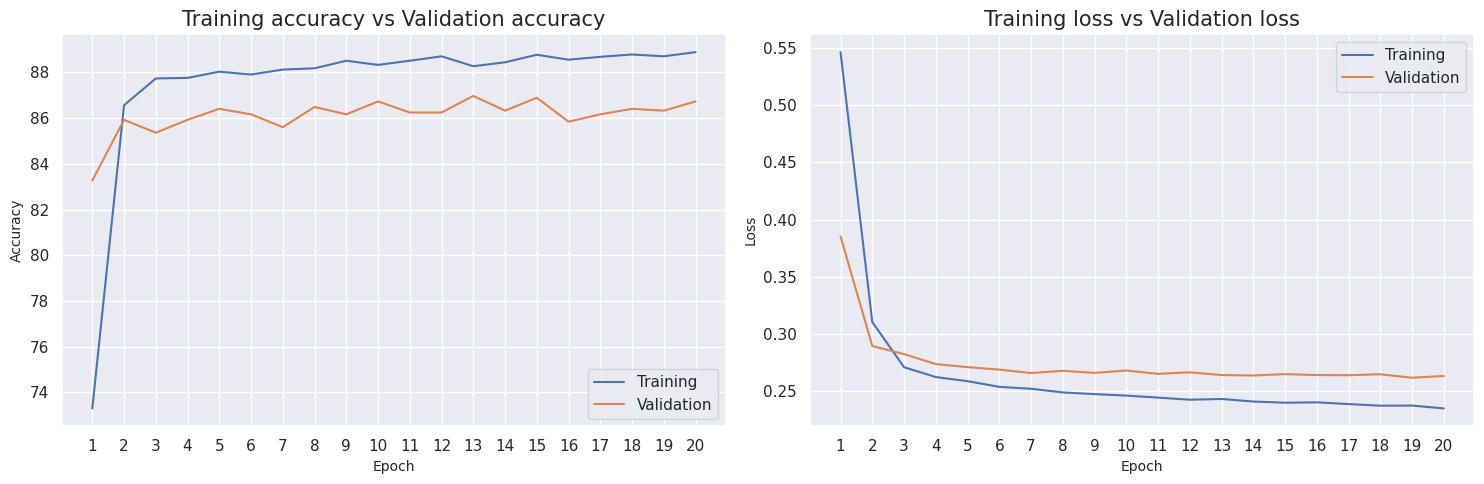

In [101]:
model1 = NN_model1(input_size = 20) 
model1 = model1.to(device)
optimizer = optim.Adam(model1.parameters(), lr = 0.001)
results = train_model(model1, 20, optimizer, train_loader, val_loader, device = device)

In [104]:
class NN_model2(nn.Module):
    def __init__(self, input_size):
        super(NN_model2, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.274 | Val Loss: 0.263 | Train Acc: 87.664 | Val Acc: 87.128: 100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


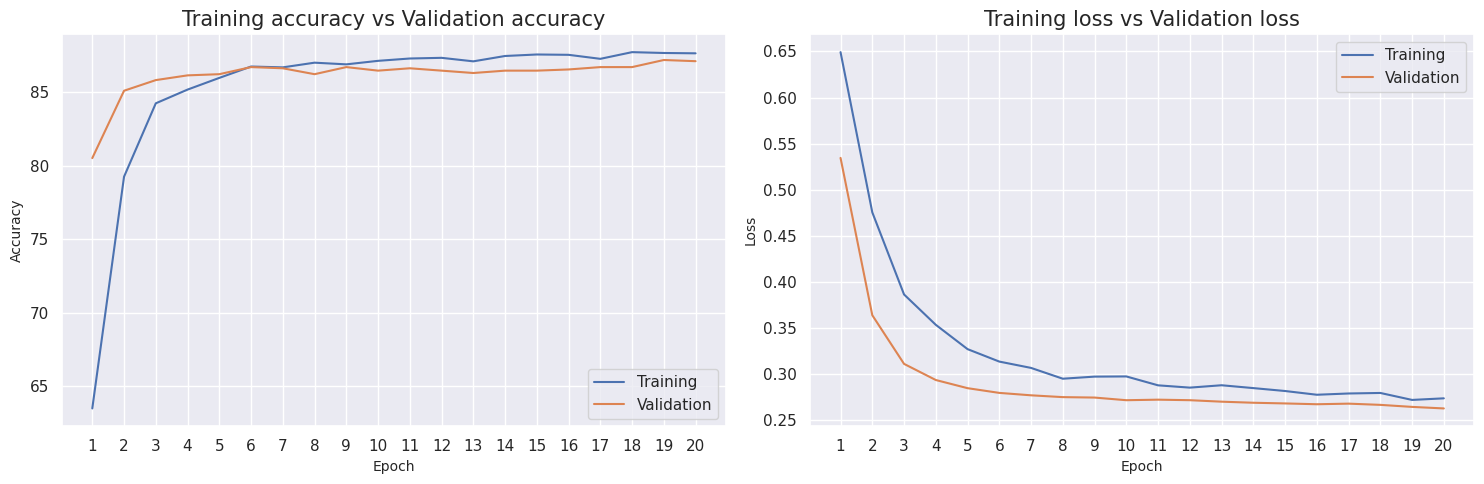

In [105]:
model2 = NN_model2(input_size = 20)
model2 = model2.to(device)
optimizer = optim.Adam(model2.parameters(), lr = 0.001)
reults = train_model(model2, 20, optimizer, train_loader, val_loader, device = device)

In [106]:
class NN_model3(nn.Module):
    def __init__(self, input_size):
        super(NN_model3, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.222 | Val Loss: 0.261 | Train Acc: 89.314 | Val Acc: 86.243: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


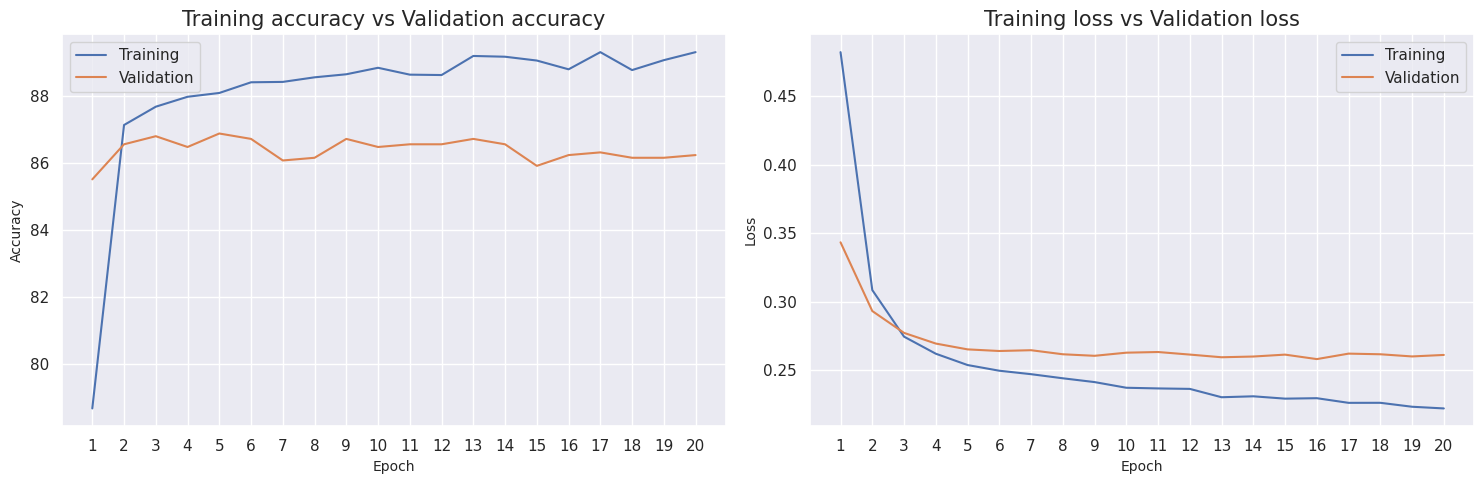

In [107]:
model3 = NN_model3(input_size = 20)
model3 = model3.to(device)
optimizer = optim.Adam(model3.parameters(), lr = 0.001)
results = train_model(model3, 20, optimizer, train_loader, val_loader, device = device)

In [109]:
class NN_model4(nn.Module):
    def __init__(self, input_size):
        super(NN_model4, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 0.293 | Val Loss: 0.270 | Train Acc: 86.742 | Val Acc: 86.243: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


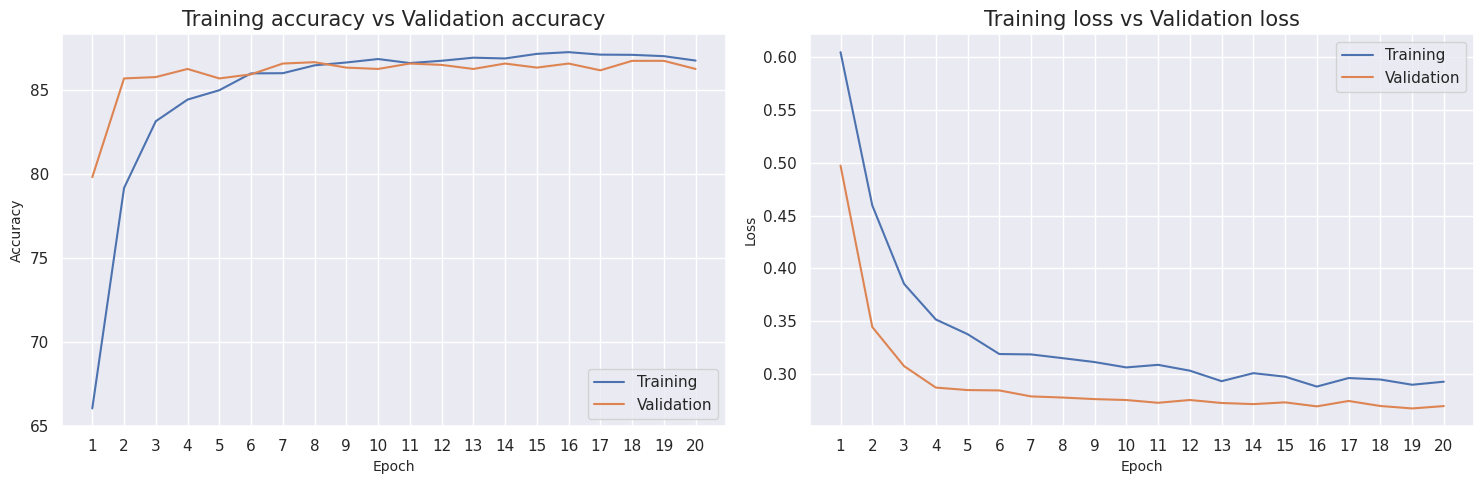

In [110]:
model4 = NN_model4(input_size = 20)
model4 = model4.to(device)
optimizer = optim.Adam(model4.parameters(), lr = 0.001)
results = train_model(model4, 20, optimizer, train_loader, val_loader, device = device)

In [112]:
criterion = nn.BCEWithLogitsLoss()
total_loss = 0
total_acc = 0
actual_labels, predicted_labels = [], []
model2.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device).float(), y.to(device).float().unsqueeze(1)
        preds = model2(x)
        loss = criterion(preds, y)
        probs = torch.sigmoid(preds)
        preds = (probs > 0.5).float()
        total_loss += loss.item()
        total_acc += (preds == y).sum().item()
        actual_labels.append(y)
        predicted_labels.append(preds)
print(f'Test Loss: {total_loss / len(test_loader)} | Test Accuracy: {100 * total_acc / len(test_loader.dataset)}')

Test Loss: 0.26827174685895444 | Test Accuracy: 86.99960364645264


In [129]:
ac_l = [t.cpu().numpy() for t in actual_labels]

In [130]:
labels = np.vstack(ac_l)

In [131]:
pr_l = [t.cpu().numpy() for t in predicted_labels]

In [132]:
preds = np.vstack(pr_l)

In [134]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      1298
         1.0       0.83      0.92      0.87      1225

    accuracy                           0.87      2523
   macro avg       0.87      0.87      0.87      2523
weighted avg       0.87      0.87      0.87      2523



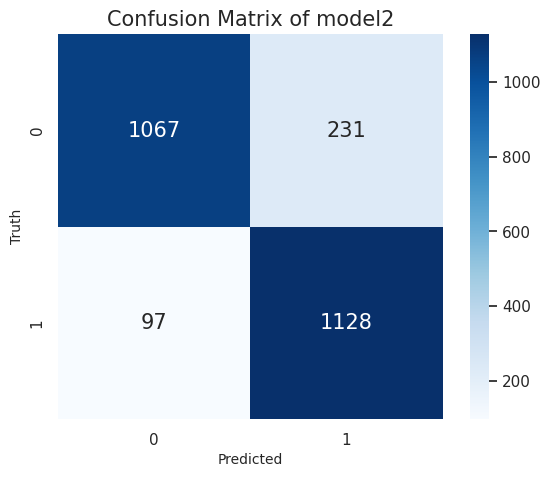

In [135]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(labels, preds), annot = True, square = True, cbar = True, annot_kws = {'size': 15}, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix of model2', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()